Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


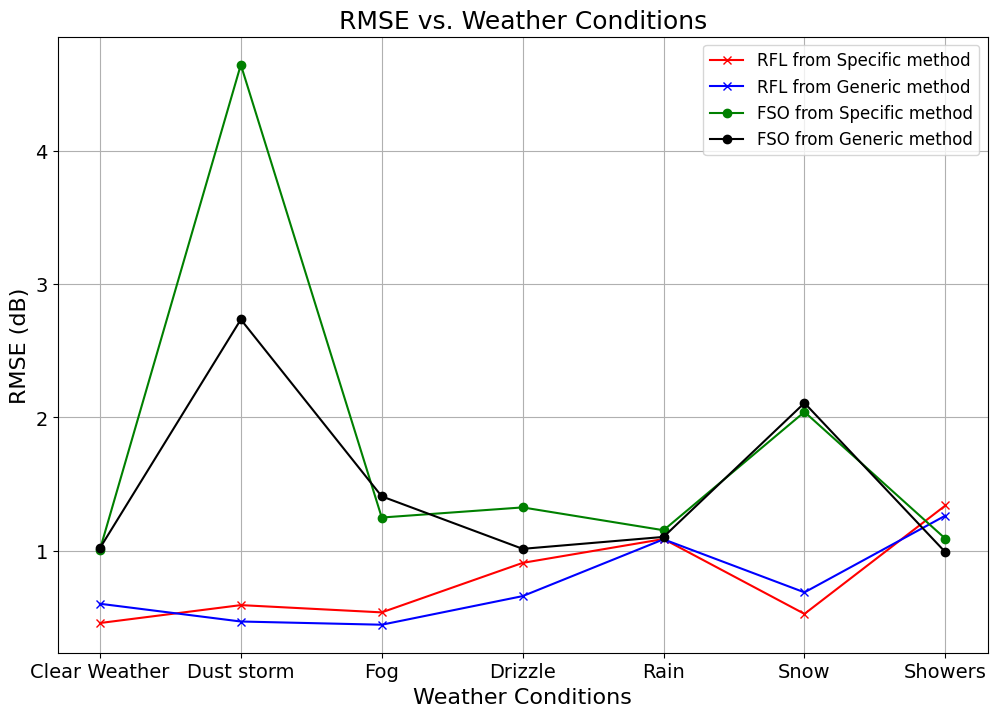

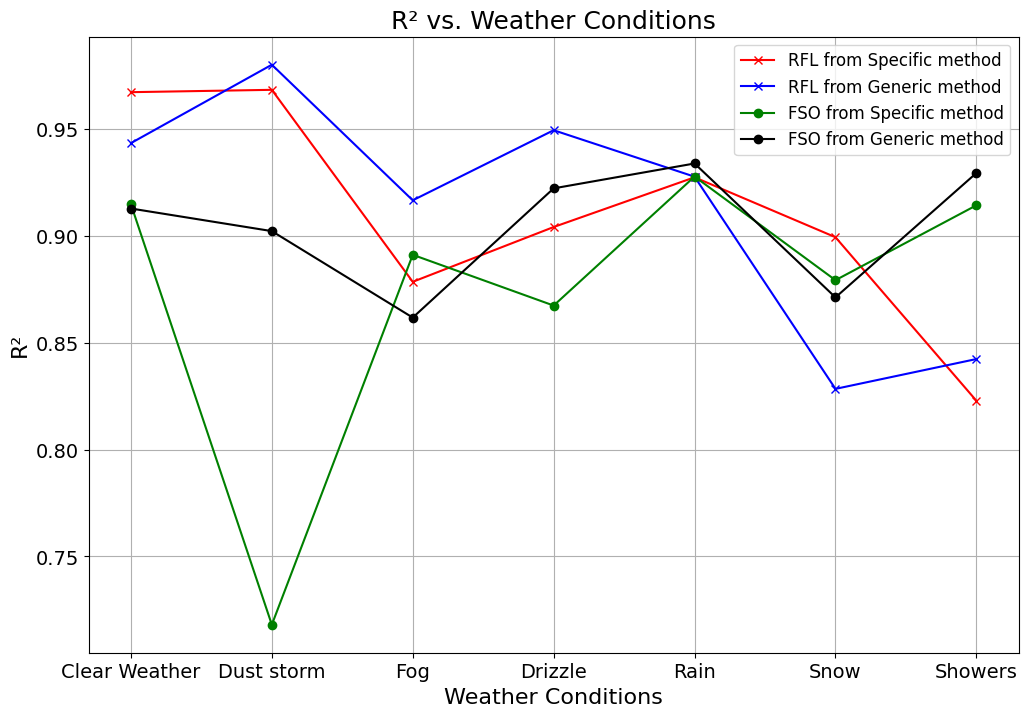

  Weather Conditions  RFL Specific RMSE  RFL Generic RMSE  RFL RMSE Diff  \
0      Clear Weather           0.459006          0.603500       0.144494   
1         Dust storm           0.593308          0.470384      -0.122925   
2                Fog           0.538840          0.446312      -0.092528   
3            Drizzle           0.909990          0.660785      -0.249205   
4               Rain           1.088850          1.086728      -0.002121   
5               Snow           0.527541          0.688928       0.161387   
6            Showers           1.340167          1.264231      -0.075936   

   RFL RMSE %  FSO Specific RMSE  FSO Generic RMSE  FSO RMSE Diff  FSO RMSE %  \
0   31.479767           1.009030          1.020637       0.011607    1.150291   
1  -20.718488           4.644822          2.734905      -1.909917  -41.119273   
2  -17.171650           1.249961          1.408658       0.158697   12.696124   
3  -27.385477           1.325833          1.015210      -0.310623  

,Weather Conditions,RFL Specific RMSE,RFL Generic RMSE,RFL RMSE Diff,RFL RMSE %,FSO Specific RMSE,FSO Generic RMSE,FSO RMSE Diff,FSO RMSE %,RFL Specific R²,RFL Generic R²,RFL R² Diff,RFL R² %,FSO Specific R²,FSO Generic R²,FSO R² Diff,FSO R² %
0,Clear Weather,0.459006,0.603500,0.144494,31.479767,1.009030,1.020637,0.011607,1.150291,0.967276,0.943431,-0.023846,-2.465231,0.914807,0.912836,-0.001971,-0.215477
1,Dust storm,0.593308,0.470384,-0.122925,-20.718488,4.644822,2.734905,-1.909917,-41.119273,0.968374,0.980121,0.011747,1.213101,0.718065,0.902255,0.184190,25.650803
2,Fog,0.538840,0.446312,-0.092528,-17.171650,1.249961,1.408658,0.158697,12.696124,0.878533,0.916667,0.038134,4.340644,0.891177,0.861790,-0.029387,-3.297535
3,Drizzle,0.909990,0.660785,-0.249205,-27.385477,1.325833,1.015210,-0.310623,-23.428492,0.904168,0.949469,0.045301,5.010222,0.867415,0.922263,0.054848,6.323109
4,Rain,1.088850,1.086728,-0.002121,-0.194813,1.154629,1.104643,-0.049986,-4.329173,0.927442,0.927724,0.000282,0.030452,0.927791,0.933908,0.006117,0.659279
5,Snow,0.527541,0.688928,0.161387,30.592375,2.041734,2.108751,0.067016,3.282322,0.899399,0.828431,-0.070968,-7.890568,0.879294,0.871240,-0.008054,-0.915960
6,Showers,1.340167,1.264231,-0.075936,-5.666173,1.091290,0.990338,-0.100953,-9.250751,0.822887,0.842389,0.019502,2.370007,0.914334,0.929451,0.015116,1.653262


In [6]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import numpy as np
import matplotlib.pyplot as plt

def rank_feature_importance(X, y):
    S = list(X.columns)
    R = []

    while S:
        model = RandomForestRegressor(n_estimators=50, min_samples_leaf=10, min_samples_split=2, max_depth=22, random_state=42, oob_score=True)
        model.fit(X[S], y)

        importances = model.feature_importances_
        y_pred = model.oob_prediction_
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        r2 = r2_score(y, y_pred)

        R.append({
            'Features': S.copy(),
            'RMSE': rmse,
            'R2': r2,
            'Least Important Feature': None
        })

        least_important_feature = S[np.argmin(importances)]
        S.remove(least_important_feature)

        R[-1]['Least Important Feature'] = least_important_feature

    return pd.DataFrame(R)

def save_plot(ranking_table, title, num_observations, manual_dividing_line=False, keep_features=6):
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.set_xlabel('Features', fontsize=16)
    ax.set_ylabel('RMSE(dB)', color='tab:blue', fontsize=16)
    ax.plot(ranking_table.index, ranking_table['RMSE'], color='tab:blue', marker='o', label='RMSE')
    ax.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
    ax.tick_params(axis='x', rotation=90, labelsize=14)

    ax2 = ax.twinx()
    ax2.set_ylabel('R²', color='tab:orange', fontsize=16)
    ax2.plot(ranking_table.index, ranking_table['R2'], color='tab:orange', marker='x', label='R²')
    ax2.tick_params(axis='y', labelcolor='tab:orange', labelsize=14)

    if manual_dividing_line:
        dividing_point = len(ranking_table) - keep_features
    else:
        dividing_point = None
        threshold = 0.005
        for i in range(1, len(ranking_table)):
            rmse_change = (ranking_table.loc[i, 'RMSE'] - ranking_table.loc[i-1, 'RMSE']) / ranking_table.loc[i-1, 'RMSE']
            r2_change = (ranking_table.loc[i-1, 'R2'] - ranking_table.loc[i, 'R2']) / ranking_table.loc[i-1, 'R2']
            if rmse_change > threshold and r2_change > threshold:
                dividing_point = i - 1
                break

    if dividing_point is not None:
        ax.axvline(x=dividing_point + 0.5, color='green', linestyle='--', label='Dividing Line')

    ax.set_title(f'{title} (observations={num_observations})', fontsize=18)
    ax.set_xticks(ranking_table.index)
    ax.set_xticklabels(ranking_table['Least Important Feature'], rotation=90, fontsize=12)
    plt.tight_layout()

    if dividing_point is not None:
        important_features = ranking_table.loc[dividing_point + 1:, 'Least Important Feature'].tolist()
    else:
        important_features = []

    plt.savefig(f'/content/drive/MyDrive/data/{title}.png')
    plt.close(fig)

    return important_features

def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)

    columns_dict = {
        "FSO_Att":"FSO_Att",
        "RFL_Att":"RFL_Att",
        "AbsoluteHumidity":"AH",
        "AbsoluteHumidityMax":"AH_Max",
        "AbsoluteHumidityMin":"AH_Min",
        "Distance":"Dist",
        "Frequency":"Freq",
        "Particulate":"Part",
        "ParticulateMax":"Part_Max",
        "ParticulateMin":"Part_Min",
        "RainIntensity":"RainInt",
        "RainIntensityMax":"RainInt_Max",
        "RainIntensityMin":"RainInt_Min",
        "RelativeHumidity":"RH",
        "SYNOPCode":"SYNOPCode",
        "Temperature":"Temp",
        "TemperatureDifference":"TDiff",
        "TemperatureMax":"Temp_Max",
        "TemperatureMin":"Temp_Min",
        "Time":"Time",
        "Visibility":"Visi",
        "VisibilityMax":"Visi_Max",
        "VisibilityMin":"Visi_Min",
        "WindDirection":"WD",
        "WindSpeed":"WS",
        "WindSpeedMax":"WS_Max",
        "WindSpeedMin":"WS_Min"
    }
    data.rename(columns=columns_dict, inplace=True)

    # Define categorical and numerical features
    categorical_features = ['Freq', 'Time', 'SYNOPCode']
    numerical_features = [col for col in data.columns if col not in categorical_features + ['FSO_Att', 'RFL_Att']]

    # Handle missing values
    data = data.dropna()

    # Handle outliers for numerical columns using RobustScaler
    scaler = RobustScaler()
    data[numerical_features] = scaler.fit_transform(data[numerical_features])

    return data, categorical_features, numerical_features

def train_model(X_train, y_train, important_features):
    X_train = X_train[important_features]
    model = RandomForestRegressor(n_estimators=50, min_samples_leaf=10, min_samples_split=2, max_depth=22, random_state=42, oob_score=True)
    model.fit(X_train, y_train)
    return model

def get_predictions_and_metrics(X_test, y_test, models_dict, important_features_dict, default_model=None, default_features=None):
    predictions = []
    for i, row in X_test.iterrows():
        synop_code = row['SYNOPCode']
        if synop_code in important_features_dict and important_features_dict[synop_code]:
            X_test_row = row[important_features_dict[synop_code]].to_frame().T
            if synop_code in models_dict:
                pred = models_dict[synop_code].predict(X_test_row)[0]
            elif default_model and default_features:
                X_test_row_default = row[default_features].to_frame().T
                pred = default_model.predict(X_test_row_default)[0]
            else:
                pred = np.nan
        else:
            if default_model and default_features:
                X_test_row_default = row[default_features].to_frame().T
                pred = default_model.predict(X_test_row_default)[0]
            else:
                pred = np.nan
        predictions.append(pred)

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)

    return predictions, rmse, r2

# Load and preprocess the data
data, categorical_features, numerical_features = load_and_preprocess_data('/content/drive/MyDrive/data/RFLFSODataFull.csv')

# Split the data into training and testing sets
X = data.drop(columns=['FSO_Att', 'RFL_Att'])
y_fso = data['FSO_Att']
y_rfl = data['RFL_Att']

# Split the data into training, validation, and testing sets for FSO
X_train_fso, X_temp_fso, y_train_fso, y_temp_fso = train_test_split(X, y_fso, test_size=0.3, random_state=42)
X_val_fso, X_test_fso, y_val_fso, y_test_fso = train_test_split(X_temp_fso, y_temp_fso, test_size=0.5, random_state=42)

# Split the data into training, validation, and testing sets for RFL
X_train_rfl, X_temp_rfl, y_train_rfl, y_temp_rfl = train_test_split(X, y_rfl, test_size=0.3, random_state=42)
X_val_rfl, X_test_rfl, y_val_rfl, y_test_rfl = train_test_split(X_temp_rfl, y_temp_rfl, test_size=0.5, random_state=42)

# Now further divide the training data into subsets based on SYNOPCode
models_fso = {}
important_features_fso = {}
models_rfl = {}
important_features_rfl = {}

rmse_fso_dict = {}
r2_fso_dict = {}
rmse_rfl_dict = {}
r2_rfl_dict = {}

synop_codes_order = [0, 3, 4, 5, 6, 7, 8]
synop_code_labels = ['Clear Weather', 'Dust storm', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers']

for i, synop_code in enumerate(synop_codes_order):
    manual_dividing_line = (synop_code == 3)
    keep_features_fso = 6
    keep_features_rfl = 9

    subset_train_fso = X_train_fso[X_train_fso['SYNOPCode'] == synop_code]
    subset_train_rfl = X_train_rfl[X_train_rfl['SYNOPCode'] == synop_code]
    subset_y_train_fso = y_train_fso[subset_train_fso.index]
    subset_y_train_rfl = y_train_rfl[subset_train_rfl.index]

    if len(subset_train_fso) > 0:
        ranking_table_fso = rank_feature_importance(subset_train_fso, subset_y_train_fso)
        important_features_fso[synop_code] = save_plot(ranking_table_fso, f'Feature_Selection_FSO_SYNOPCode_{synop_code_labels[i]}', len(subset_train_fso), manual_dividing_line, keep_features_fso)
        models_fso[synop_code] = train_model(subset_train_fso, subset_y_train_fso, important_features_fso[synop_code])

    if len(subset_train_rfl) > 0:
        ranking_table_rfl = rank_feature_importance(subset_train_rfl, subset_y_train_rfl)
        important_features_rfl[synop_code] = save_plot(ranking_table_rfl, f'Feature_Selection_RFL_SYNOPCode_{synop_code_labels[i]}', len(subset_train_rfl), manual_dividing_line, keep_features_rfl)
        models_rfl[synop_code] = train_model(subset_train_rfl, subset_y_train_rfl, important_features_rfl[synop_code])

ranking_table_fso_generic = rank_feature_importance(X_train_fso, y_train_fso)
important_features_fso_generic = save_plot(ranking_table_fso_generic, 'Feature_Selection_FSO_Generic', len(X_train_fso), manual_dividing_line=False, keep_features=6)
model_fso_generic = train_model(X_train_fso, y_train_fso, important_features_fso_generic)

ranking_table_rfl_generic = rank_feature_importance(X_train_rfl, y_train_rfl)
important_features_rfl_generic = save_plot(ranking_table_rfl_generic, 'Feature_Selection_RFL_Generic', len(X_train_rfl), manual_dividing_line=False, keep_features=9)
model_rfl_generic = train_model(X_train_rfl, y_train_rfl, important_features_rfl_generic)

results_fso = {
    'specific': {},
    'generic': {}
}
results_rfl = {
    'specific': {},
    'generic': {}
}

for i, synop_code in enumerate(synop_codes_order):
    if synop_code in models_fso:
        _, rmse_fso, r2_fso = get_predictions_and_metrics(X_val_fso[X_val_fso['SYNOPCode'] == synop_code], y_val_fso[X_val_fso['SYNOPCode'] == synop_code], models_fso, important_features_fso)
        results_fso['specific'][synop_code] = (rmse_fso, r2_fso)
    else:
        results_fso['specific'][synop_code] = (np.nan, np.nan)

    _, rmse_fso_generic, r2_fso_generic = get_predictions_and_metrics(X_val_fso[X_val_fso['SYNOPCode'] == synop_code], y_val_fso[X_val_fso['SYNOPCode'] == synop_code], {}, {}, model_fso_generic, important_features_fso_generic)
    results_fso['generic'][synop_code] = (rmse_fso_generic, r2_fso_generic)

    if synop_code in models_rfl:
        _, rmse_rfl, r2_rfl = get_predictions_and_metrics(X_val_rfl[X_val_rfl['SYNOPCode'] == synop_code], y_val_rfl[X_val_rfl['SYNOPCode'] == synop_code], models_rfl, important_features_rfl)
        results_rfl['specific'][synop_code] = (rmse_rfl, r2_rfl)
    else:
        results_rfl['specific'][synop_code] = (np.nan, np.nan)

    _, rmse_rfl_generic, r2_rfl_generic = get_predictions_and_metrics(X_val_rfl[X_val_rfl['SYNOPCode'] == synop_code], y_val_rfl[X_val_rfl['SYNOPCode'] == synop_code], {}, {}, model_rfl_generic, important_features_rfl_generic)
    results_rfl['generic'][synop_code] = (rmse_rfl_generic, r2_rfl_generic)

# Generating the required plots
weather_conditions = ['Clear Weather', 'Dust storm', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers']

def generate_final_plots(results_fso, results_rfl, metric, ylabel, plot_title):
    plt.figure(figsize=(12, 8))

    # Specific methods
    values_rfl_specific = [results_rfl['specific'][code][metric] for code in synop_codes_order]
    values_fso_specific = [results_fso['specific'][code][metric] for code in synop_codes_order]

    # Generic methods
    values_rfl_generic = [results_rfl['generic'][code][metric] for code in synop_codes_order]
    values_fso_generic = [results_fso['generic'][code][metric] for code in synop_codes_order]

    plt.plot(weather_conditions, values_rfl_specific, label='RFL from Specific method', color='red', marker='x')
    plt.plot(weather_conditions, values_rfl_generic, label='RFL from Generic method', color='blue', marker='x')
    plt.plot(weather_conditions, values_fso_specific, label='FSO from Specific method', color='green', marker='o')
    plt.plot(weather_conditions, values_fso_generic, label='FSO from Generic method', color='black', marker='o')

    plt.xlabel('Weather Conditions', fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.title(plot_title, fontsize=18)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

# Plot for RMSE
generate_final_plots(results_fso, results_rfl, metric=0, ylabel='RMSE (dB)', plot_title='RMSE vs. Weather Conditions')

# Plot for R²
generate_final_plots(results_fso, results_rfl, metric=1, ylabel='R²', plot_title='R² vs. Weather Conditions')


# Extract values
rmse_rfl_specific = [results_rfl['specific'][code][0] for code in synop_codes_order]
rmse_fso_specific = [results_fso['specific'][code][0] for code in synop_codes_order]
r2_rfl_specific = [results_rfl['specific'][code][1] for code in synop_codes_order]
r2_fso_specific = [results_fso['specific'][code][1] for code in synop_codes_order]

# Generic method values
rmse_rfl_generic = [results_rfl['generic'][code][0] for code in synop_codes_order]
rmse_fso_generic = [results_fso['generic'][code][0] for code in synop_codes_order]
r2_rfl_generic = [results_rfl['generic'][code][1] for code in synop_codes_order]
r2_fso_generic = [results_fso['generic'][code][1] for code in synop_codes_order]

# Calculate differences and percentages
rmse_rfl_diff = [gen - spec for gen, spec in zip(rmse_rfl_generic, rmse_rfl_specific)]
rmse_fso_diff = [gen - spec for gen, spec in zip(rmse_fso_generic, rmse_fso_specific)]
r2_rfl_diff = [gen - spec for gen, spec in zip(r2_rfl_generic, r2_rfl_specific)]
r2_fso_diff = [gen - spec for gen, spec in zip(r2_fso_generic, r2_fso_specific)]

rmse_rfl_percent = [diff / spec * 100 if spec != 0 else 0 for diff, spec in zip(rmse_rfl_diff, rmse_rfl_specific)]
rmse_fso_percent = [diff / spec * 100 if spec != 0 else 0 for diff, spec in zip(rmse_fso_diff, rmse_fso_specific)]
r2_rfl_percent = [diff / spec * 100 if spec != 0 else 0 for diff, spec in zip(r2_rfl_diff, r2_rfl_specific)]
r2_fso_percent = [diff / spec * 100 if spec != 0 else 0 for diff, spec in zip(r2_fso_diff, r2_fso_specific)]

# Create a DataFrame to hold the results
table_data = {
    'Weather Conditions': weather_conditions,
    'RFL Specific RMSE': rmse_rfl_specific,
    'RFL Generic RMSE': rmse_rfl_generic,
    'RFL RMSE Diff': rmse_rfl_diff,
    'RFL RMSE %': rmse_rfl_percent,
    'FSO Specific RMSE': rmse_fso_specific,
    'FSO Generic RMSE': rmse_fso_generic,
    'FSO RMSE Diff': rmse_fso_diff,
    'FSO RMSE %': rmse_fso_percent,
    'RFL Specific R²': r2_rfl_specific,
    'RFL Generic R²': r2_rfl_generic,
    'RFL R² Diff': r2_rfl_diff,
    'RFL R² %': r2_rfl_percent,
    'FSO Specific R²': r2_fso_specific,
    'FSO Generic R²': r2_fso_generic,
    'FSO R² Diff': r2_fso_diff,
    'FSO R² %': r2_fso_percent
}

results_table = pd.DataFrame(table_data)
print(results_table)
results_table

In [5]:
# Debug print statements
print("Results RFL Specific:", results_rfl['specific'])
print("Results FSO Specific:", results_fso['specific'])

# Extract values
rmse_rfl_specific = [results_rfl['specific'][code][0] for code in synop_codes_order]
rmse_fso_specific = [results_fso['specific'][code][0] for code in synop_codes_order]
r2_rfl_specific = [results_rfl['specific'][code][1] for code in synop_codes_order]
r2_fso_specific = [results_fso['specific'][code][1] for code in synop_codes_order]

# Generic method values
rmse_rfl_generic = [results_rfl['generic'][code][0] for code in synop_codes_order]
rmse_fso_generic = [results_fso['generic'][code][0] for code in synop_codes_order]
r2_rfl_generic = [results_rfl['generic'][code][1] for code in synop_codes_order]
r2_fso_generic = [results_fso['generic'][code][1] for code in synop_codes_order]

# Calculate differences and percentages
rmse_rfl_diff = [gen - spec for gen, spec in zip(rmse_rfl_generic, rmse_rfl_specific)]
rmse_fso_diff = [gen - spec for gen, spec in zip(rmse_fso_generic, rmse_fso_specific)]
r2_rfl_diff = [gen - spec for gen, spec in zip(r2_rfl_generic, r2_rfl_specific)]
r2_fso_diff = [gen - spec for gen, spec in zip(r2_fso_generic, r2_fso_specific)]

rmse_rfl_percent = [diff / spec * 100 if spec != 0 else 0 for diff, spec in zip(rmse_rfl_diff, rmse_rfl_specific)]
rmse_fso_percent = [diff / spec * 100 if spec != 0 else 0 for diff, spec in zip(rmse_fso_diff, rmse_fso_specific)]
r2_rfl_percent = [diff / spec * 100 if spec != 0 else 0 for diff, spec in zip(r2_rfl_diff, r2_rfl_specific)]
r2_fso_percent = [diff / spec * 100 if spec != 0 else 0 for diff, spec in zip(r2_fso_diff, r2_fso_specific)]

# Create a DataFrame to hold the results
table_data = {
    'Weather Conditions': weather_conditions,
    'RFL Specific RMSE': rmse_rfl_specific,
    'RFL Generic RMSE': rmse_rfl_generic,
    'RFL RMSE Diff': rmse_rfl_diff,
    'RFL RMSE %': rmse_rfl_percent,
    'FSO Specific RMSE': rmse_fso_specific,
    'FSO Generic RMSE': rmse_fso_generic,
    'FSO RMSE Diff': rmse_fso_diff,
    'FSO RMSE %': rmse_fso_percent,
    'RFL Specific R²': r2_rfl_specific,
    'RFL Generic R²': r2_rfl_generic,
    'RFL R² Diff': r2_rfl_diff,
    'RFL R² %': r2_rfl_percent,
    'FSO Specific R²': r2_fso_specific,
    'FSO Generic R²': r2_fso_generic,
    'FSO R² Diff': r2_fso_diff,
    'FSO R² %': r2_fso_percent
}

results_table = pd.DataFrame(table_data)
print(results_table)


Results RFL Specific: {0: (0.45900591629225446, 0.9672762093538266), 3: (0.5933084052155941, 0.9683738301529163), 4: (0.5388401375080206, 0.878533394105674), 5: (0.9099900008252958, 0.9041684267141383), 6: (1.088849524923117, 0.9274420644742445), 7: (0.5275406202347721, 0.8993989477824673), 8: (1.340166903082562, 0.8228866267929469)}
Results FSO Specific: {0: (1.0090301704030182, 0.9148074241539743), 3: (4.644822233432901, 0.7180654290467178), 4: (1.2499613685596482, 0.8911765531519493), 5: (1.3258325623923732, 0.8674154714262572), 6: (1.154629164867318, 0.9277914654187139), 7: (2.0417343892605464, 0.8792937101521499), 8: (1.0912901415299017, 0.9143343280413848)}
  Weather Conditions  RFL Specific RMSE  RFL Generic RMSE  RFL RMSE Diff  \
0      Clear Weather           0.459006          0.603500       0.144494   
1         Dust storm           0.593308          0.470384      -0.122925   
2                Fog           0.538840          0.446312      -0.092528   
3            Drizzle    

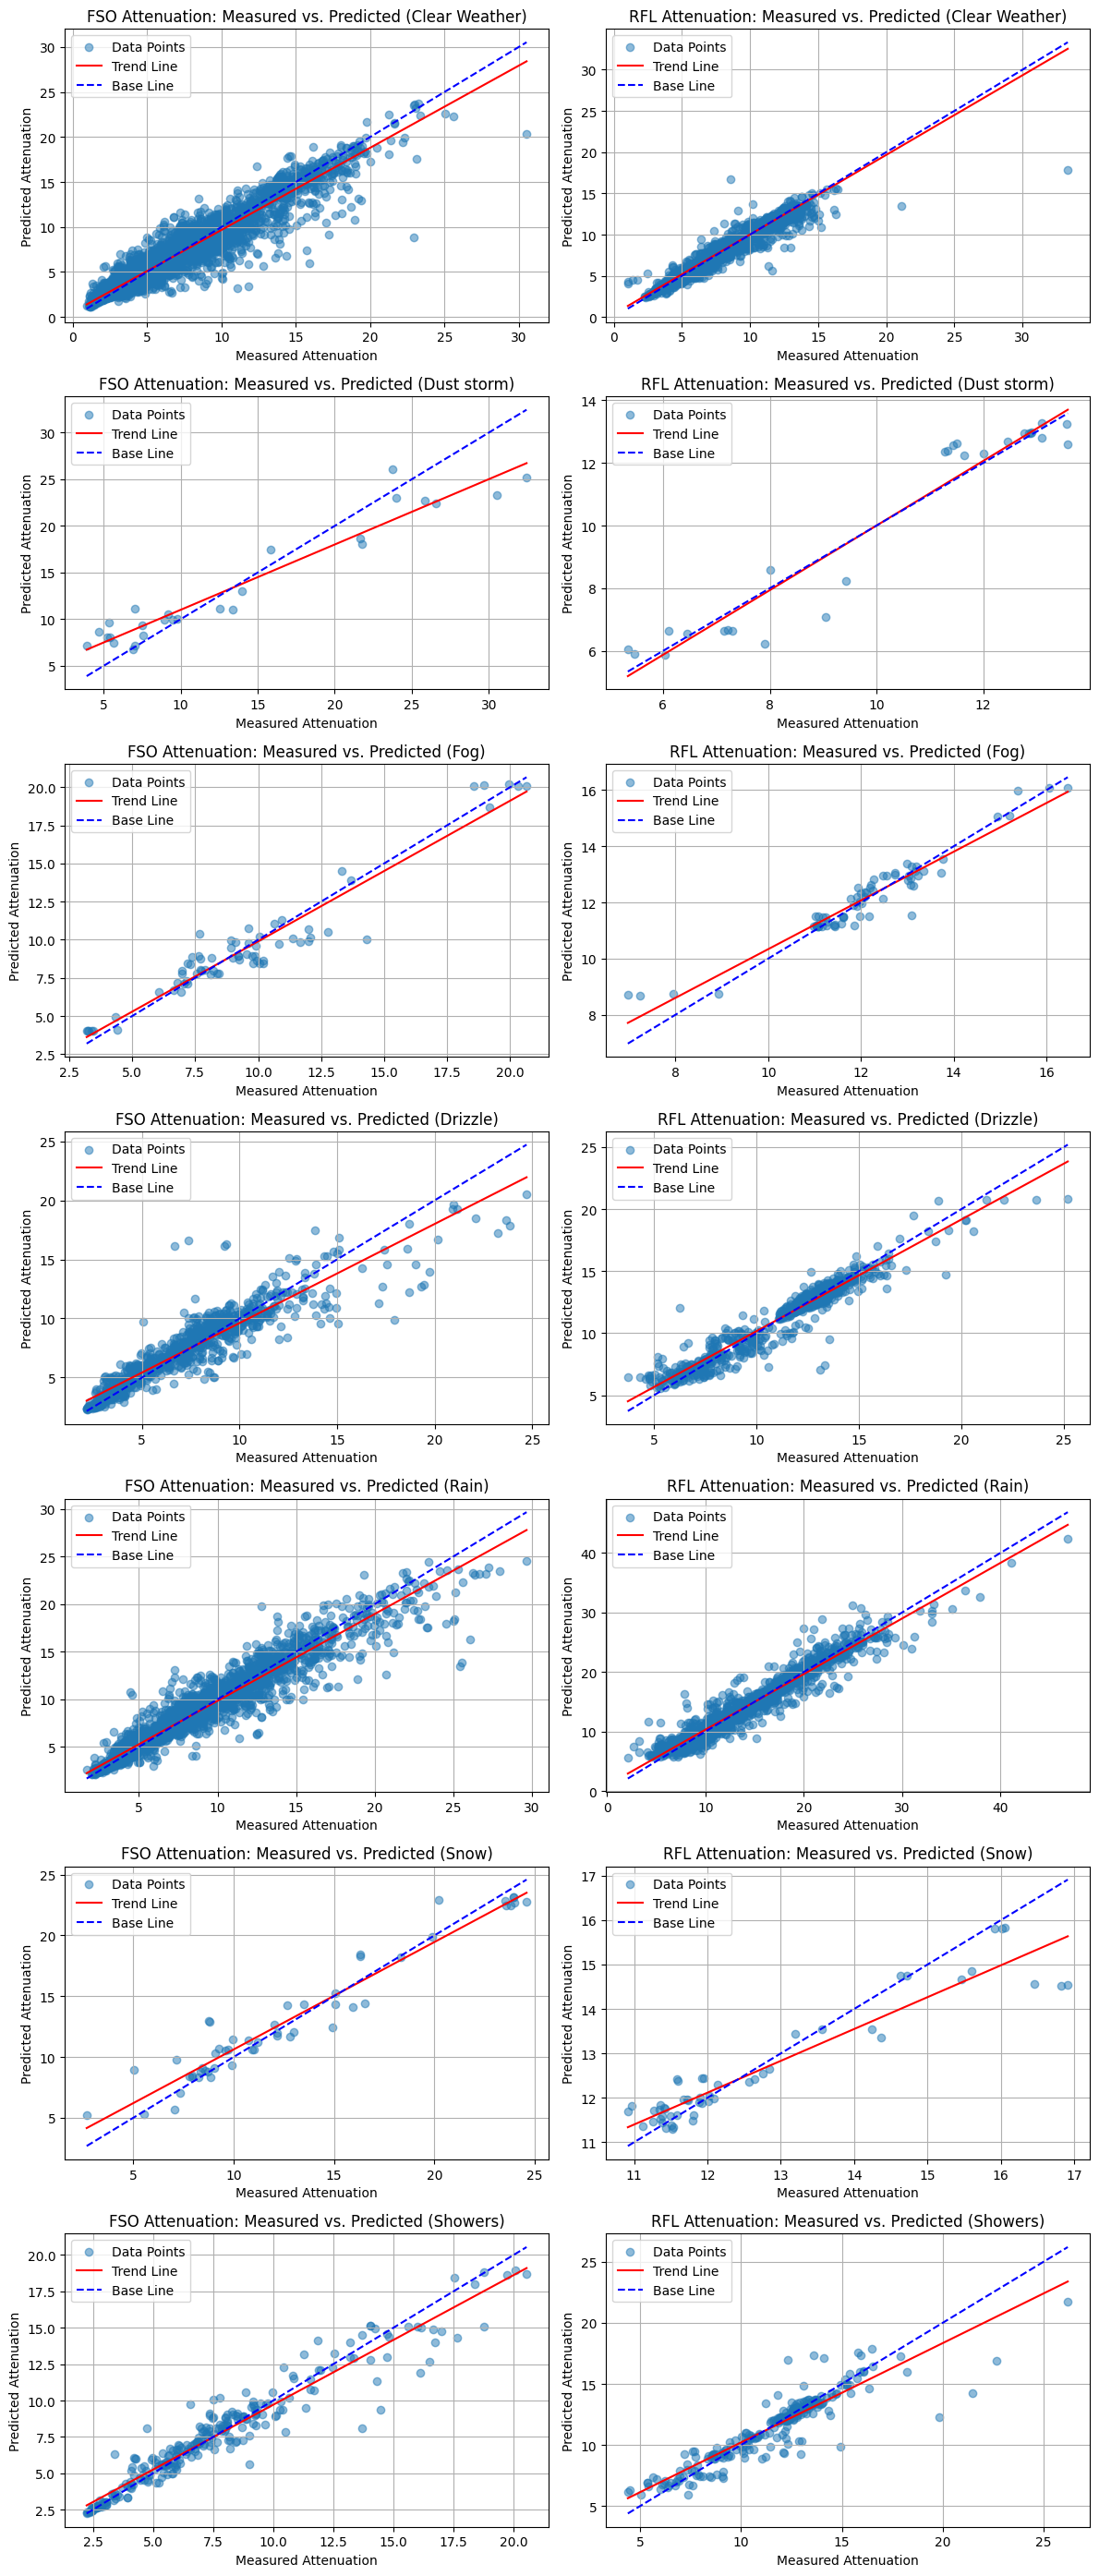

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def generate_grid_plots(X_test_fso, y_test_fso, X_test_rfl, y_test_rfl, models_fso, models_rfl, important_features_fso, important_features_rfl, title_prefix_fso, title_prefix_rfl, synop_code_labels, synop_codes_order):
    num_synop_codes = len(synop_codes_order)

    # Create subplots with rows for SYNOP codes and columns for FSO and RFL
    fig, axes = plt.subplots(num_synop_codes, 2, figsize=(12, 4 * num_synop_codes))  # Adjust height based on number of SYNOP codes

    for i, synop_code in enumerate(synop_codes_order):
        # Filter data by SYNOP code
        subset_test_fso = X_test_fso[X_test_fso['SYNOPCode'] == synop_code]
        y_true_fso = y_test_fso[subset_test_fso.index]
        subset_test_rfl = X_test_rfl[X_test_rfl['SYNOPCode'] == synop_code]
        y_true_rfl = y_test_rfl[subset_test_rfl.index]

        # Get predictions for FSO
        y_pred_fso, _, _ = get_predictions_and_metrics(subset_test_fso, y_true_fso, models_fso, important_features_fso)
        # Get predictions for RFL
        y_pred_rfl, _, _ = get_predictions_and_metrics(subset_test_rfl, y_true_rfl, models_rfl, important_features_rfl)

        # Plot FSO scatter comparison
        ax_fso = axes[i, 0]
        ax_fso.scatter(y_true_fso, y_pred_fso, alpha=0.5, label='Data Points')

        # Trend line for FSO
        coeffs_fso = np.polyfit(y_true_fso, y_pred_fso, 1)  # Linear fit
        trend_line_fso = np.poly1d(coeffs_fso)
        ax_fso.plot(np.sort(y_true_fso), trend_line_fso(np.sort(y_true_fso)), 'r-', label='Trend Line')

        # Base line for FSO (y = x)
        ax_fso.plot([min(y_true_fso), max(y_true_fso)], [min(y_true_fso), max(y_true_fso)], 'b--', label='Base Line')

        ax_fso.set_xlabel('Measured Attenuation')
        ax_fso.set_ylabel('Predicted Attenuation')
        ax_fso.set_title(f'{title_prefix_fso}: Measured vs. Predicted ({synop_code_labels[synop_code]})')
        ax_fso.grid(True)
        ax_fso.legend()

        # Plot RFL scatter comparison
        ax_rfl = axes[i, 1]
        ax_rfl.scatter(y_true_rfl, y_pred_rfl, alpha=0.5, label='Data Points')

        # Trend line for RFL
        coeffs_rfl = np.polyfit(y_true_rfl, y_pred_rfl, 1)  # Linear fit
        trend_line_rfl = np.poly1d(coeffs_rfl)
        ax_rfl.plot(np.sort(y_true_rfl), trend_line_rfl(np.sort(y_true_rfl)), 'r-', label='Trend Line')

        # Base line for RFL (y = x)
        ax_rfl.plot([min(y_true_rfl), max(y_true_rfl)], [min(y_true_rfl), max(y_true_rfl)], 'b--', label='Base Line')

        ax_rfl.set_xlabel('Measured Attenuation')
        ax_rfl.set_ylabel('Predicted Attenuation')
        ax_rfl.set_title(f'{title_prefix_rfl}: Measured vs. Predicted ({synop_code_labels[synop_code]})')
        ax_rfl.grid(True)
        ax_rfl.legend()

    plt.tight_layout()
    plt.show()

# Example SYNOP code labels and order
synop_code_labels = {
    0: 'Clear Weather',
    3: 'Dust storm',
    4: 'Fog',
    5: 'Drizzle',
    6: 'Rain',
    7: 'Snow',
    8: 'Showers'
}

# Select all SYNOP codes for grid layout
synop_codes_order = [0, 3, 4, 5, 6, 7, 8]  # All weather conditions

# Generate grid plots for FSO and RFL attenuation
generate_grid_plots(X_test_fso, y_test_fso, X_test_rfl, y_test_rfl, models_fso, models_rfl, important_features_fso, important_features_rfl, 'FSO Attenuation', 'RFL Attenuation', synop_code_labels, synop_codes_order)
